In [36]:
import os
from os import listdir
from os.path import isfile, join
import random
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torchvision import transforms, models
from PIL import Image
import cv2
from sklearn.cluster import KMeans, MiniBatchKMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

USE_CUDA = torch.cuda.is_available()
if USE_CUDA:
    print("CUDA Available")

CUDA Available


In [37]:
# USE_CUDA = False

In [62]:
PATH = "./EyesDataset/"
COSINE = True
ONES_PATH = "./T1/"
ZEROS_PATH = "./T0/"

TEST_PATH = "./EyesDatasetTest/"

# MODEL_PATH = "./custom_res.pth"
# MODEL_PATH = "./res18_224_64.pth"
# MODEL_PATH = "./res18_224_64_330.pth"
MODEL_PATH = "./res18_224_64_150+.pth"
# MODEL_PATH = "./ef_b4_224_64.pth"
# MODEL_PATH = "./res18_2out_224_64.pth"

IMG_SIZE = (24, 24)
NEW_SIZE = (224, 224)

In [39]:
TO_TENSOR = transforms.ToTensor()
RESIZE = transforms.Resize(NEW_SIZE)
NORMALIZE = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
IMAGE_TRANSFORMS = transforms.Compose([        
        RESIZE,
#         transforms.RandomHorizontalFlip(p=0.5), 
        transforms.RandomRotation(20),        
        transforms.RandomAffine(degrees=20, translate=(0, 0.1), scale=(0.8, 1.25)),
        NORMALIZE,
    ])
TEST_TRANSFORMS = transforms.Compose([
        RESIZE,
        NORMALIZE,
    ])

In [40]:
def get_image_names_from_dir(path, full=False):
    ''' Returns list of file names and full paths in directory, 
        if full==False, then list of names only.
    '''
    if full:
        return [join(path, f) for f in listdir(path) if isfile(join(path, f))]
    else:
        return [f for f in listdir(path) if isfile(join(path, f))]

In [41]:
def show_images(image_list, amount=None, columns=16, scale=2, randomize=False, mark=True, labels=None):
    ''' Displays amount or all of scaled images in columns from image_list
        randomized if needed,
        marked with filename,
        labeleb by mark color        
    '''
    img_sum = None
    img_row = None
    if not amount or amount > len(image_list):
        amount = len(image_list)
    image_list = image_list.copy()
    if randomize:
        random.shuffle(image_list)
    for i, img_name in enumerate(image_list):
        if i == amount:
            break
        if img_row is not None and i % columns == 0:
            if img_sum is None:
                img_sum = img_row
            else:
                img_sum = np.concatenate((img_sum, img_row), axis=0)
            img_row = None
        img = cv2.imread(img_name)        
        img = cv2.resize(img, tuple(map(lambda x: scale * x, IMG_SIZE)))   
        short_name = img_name[-8:]
        if labels is not None and short_name in labels:
            label = labels[short_name]
            text_color = (int(100*(1 - label)), 0, int(100*label))
        else:
            text_color = (50,50,50)        
        if mark:
            cv2.putText(
                img=img,
                text=img_name[-8:-4], 
                org=(2, IMG_SIZE[1] * scale - 2),  # bottomLeftCornerOfText
                fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
                fontScale=0.25,
                color=text_color,
                thickness=1,
                lineType=2,
            )        
        if img_row is None:
            img_row = img
        else:
            img_row = np.concatenate((img_row, img), axis=1)
        
    if img_row is not None:
        if img_sum is None:
            img_sum = img_row
        else:
            while img_row.shape[1] // columns !=  IMG_SIZE[1] * scale:
                img_row = np.concatenate(
                    (img_row, np.ones(list(map(lambda x: scale * x, IMG_SIZE))+[3], dtype=np.uint8) * 255), 
                    axis=1
                )
            img_sum = np.concatenate((img_sum, img_row), axis=0)
        img_row = None
    if img_sum is not None:
        display(Image.fromarray(img_sum))    

In [42]:
image_list = get_image_names_from_dir(PATH, full=True)
ones_list = get_image_names_from_dir(ONES_PATH, full=True)
zeros_list = get_image_names_from_dir(ZEROS_PATH, full=True)

In [43]:
# show_images(image_list[500:], amount=100, randomize=False)

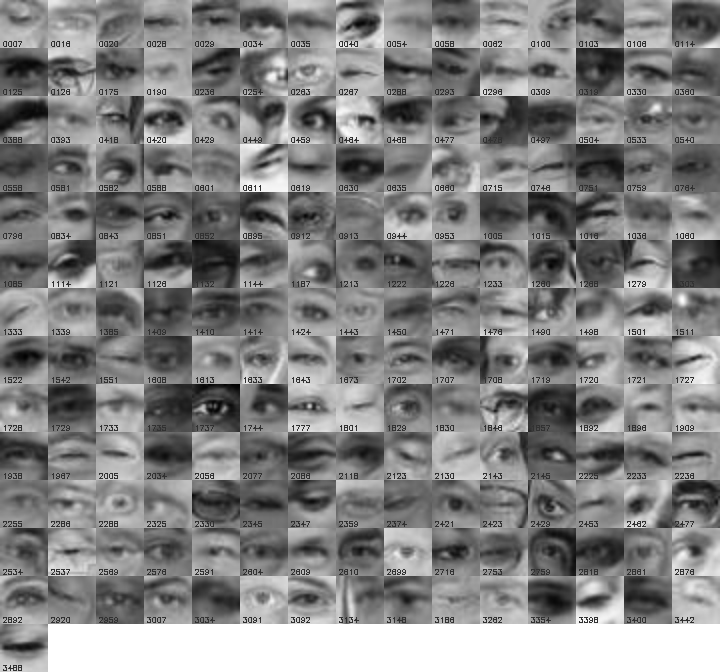

In [44]:
show_images(ones_list, columns = 15, randomize=False, mark=True)

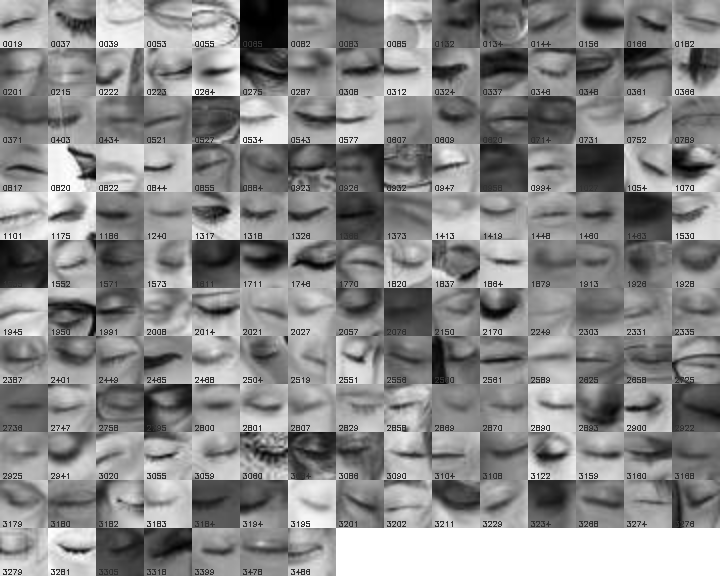

In [45]:
show_images(zeros_list, columns=15, randomize=False, mark=True)

In [47]:
class EyesDataset(torch.utils.data.Dataset):
    ''' Create dataset to format data, to use in standard Dataloader    
    '''
    def __init__(self, 
                 ones_path=ONES_PATH,
                 zeros_path=ZEROS_PATH,                 
                 train=True
                ):
        super().__init__()
        self.ones_path = ones_path
        self.zeros_path = zeros_path 
        self.train = train
        self.files = []
        files = get_image_names_from_dir(self.ones_path, full=True)        
        self.files += [pair for pair in zip(files, [1] * len(files))]
        files = get_image_names_from_dir(self.zeros_path, full=True)
        self.files += [pair for pair in zip(files, [0] * len(files))]
         
        self.ids = list(range(len(self.files))) # indices of filenames
        random.seed(0)
        random.shuffle(self.ids)
        self._len = len(self.ids) * 10
        print("Dataset length: ", self._len)
        
    def __len__(self):
        return self._len
    
    def tfs(self, image, rnd=True):
        image = TO_TENSOR(image)
        if rnd:
            image = IMAGE_TRANSFORMS(image)
        else:
            image = TEST_TRANSFORMS(image)
        return image
    
    def __getitem__(self, i):
        pair1 = random.choice(self.files)
        pair2 = random.choice(self.files)

        img_name = pair1[0]
        image = cv2.imread(img_name)
        
        if self.train:
            image1 = self.tfs(image)
        else:
            image1 = self.tfs(image, rnd=False)

        img_name = os.path.join(pair2[0])
        image = cv2.imread(img_name)
        
        if self.train:
            image2 = self.tfs(image)
        else:
            image2 = self.tfs(image, rnd=False)

        return image1, image2, (1 if pair1[1] == pair2[1] else -1)

In [48]:
trainset = EyesDataset()
# valset = EyesDataset(TEST_PATH, train=False)

Dataset length:  3680


In [19]:
# i1, i2, _ = trainset[0]

In [50]:
def make_optimizer(model, lr=1e-3):
    return torch.optim.Adam(model.parameters(), lr=lr)

In [46]:
class OuterLayer(nn.Module):
    def __init__(self, in_features, out_features, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(in_features, out_features)
        self.sigm = nn.Sigmoid()
        self.fc2 = nn.Linear(out_features, num_classes)
    
    def forward(self, x):
        x = self.fc1(x)
#         x = self.sigm(x)
        return [x, self.sigm(self.fc2(x))]

In [63]:
# model = ResNet50(img_channel=3, num_classes=256) # custom net based on resnet50 blocks
model = models.resnet18(pretrained=False, num_classes=64)
# model = models.resnet18(pretrained=True)
# model.fc = OuterLayer(in_features=model.fc.in_features, out_features=64, num_classes=2)
# model = models.efficientnet_b0(pretrained=False, num_classes=64)
x = torch.randn(2, 3, *NEW_SIZE)
model(x)[0].shape

torch.Size([64])

In [52]:
# model

In [53]:
loss = nn.CosineEmbeddingLoss(
    margin=0.0, 
    size_average=None, 
    reduce=None, 
    reduction='mean'
)

In [68]:
if USE_CUDA:
    model.cuda()
    loss.cuda()
optimizer = make_optimizer(model, lr=0.001)

In [69]:
# model.load_state_dict(torch.load(MODEL_PATH)['model_state_dict'])
# optimizer.load_state_dict(torch.load(MODEL_PATH)['optimizer_state_dict'])

In [66]:
def train_loop(model, optimizer, loss, train_loader, 
               n_iter, lr_scheduler=None, plot=None, 
               plot_kwargs={}, use_cuda=False, plot_steps=10):
    ''' Train loop
    '''    
    model.train()
    losses = []
    for i, (left, right, targets) in enumerate(train_loader):
        if i == n_iter:
            break
        if use_cuda:
            left = left.cuda()
            right = right.cuda()
            targets = targets.cuda()

#         score1, class1 = model(left)
        score1 = model(left)        
        score1 = torch.softmax(score1, dim=1)

#         score2, class2 = model(right)            
        score2 = model(right)            
        score2 = torch.softmax(score2, dim=1)
        loss_value = loss(score1, score2, targets)        
       
        optimizer.zero_grad()        
        loss_value.backward()
        optimizer.step()
        
        if lr_scheduler is not None:
            lr_scheduler.step()

        losses.append(loss_value.item())
        if i % 10 == 0:
            print("Step {} / {}, loss: {:.5f}, learning rate: {:.5f}\r".format(i, n_iter, loss_value.item(), optimizer.param_groups[0]["lr"]), end="")
    print(" " * 50 + "\r", end="")
    print("Train loss: {:.5f}, learning rate: {:.5f}".format(np.mean(losses[-plot_steps:]), optimizer.param_groups[0]["lr"]))
    return np.mean(losses)

In [57]:
USE_CUDA

True

In [58]:
def eval_model(model, loss, test_loader, batch_size,
               use_cuda=False,
               num_workers=1):
    ''' Evaluation cycle
    '''
    model.eval()
#     kwargs = {}
    losses = []
    with torch.no_grad():
        for left, right, targets in test_loader:
            if use_cuda:
                left = left.cuda()
                right = right.cuda()    
                targets = targets.cuda()

#             score1, class1 = model(left)
            score1 = model(left)            
            score1 = torch.softmax(score1, dim=1)
            
            score2, class2 = model(right)            
            score2 = torch.softmax(score2, dim=1)
            
            loss_value = loss(score1, score2, targets)

            losses.append(loss_value.item())
    test_loss = np.mean(losses)
    print("Test loss:", test_loss)
    return test_loss

In [71]:
# # this used for cache empty, to choose right batch_size
# torch.cuda.empty_cache()
# if USE_CUDA:
#     model.cuda()
#     loss.cuda()
# optimizer = make_optimizer(model)

EVALUATE = False
best_eval = 100
epoch = 0
batch_size = 32
n_iters = 2000
eval_steps = 1000
loss_storage = []
train_loss_storage = []

train_loader = torch.utils.data.DataLoader(
    trainset, 
    batch_size=batch_size,
    shuffle=True, 
    num_workers=0
    )

# test_loader = torch.utils.data.DataLoader(
#     valset, 
#     batch_size=batch_size,
#     num_workers=0
#     )

In [160]:
# for g in optimizer.param_groups:
#     g['lr'] = 0.0001

In [72]:
%%time
num_epochs = 1
while epoch < num_epochs:
    i = 0
    while i < n_iters:    
        train_steps = min(eval_steps, n_iters - i)
        train_loss = train_loop(model, optimizer, loss, train_loader, train_steps,
                   lr_scheduler=None,
                   use_cuda=USE_CUDA)
        i += train_steps       
   
    if EVALUATE:
        eval_loss = eval_model(model, loss, valset, batch_size,
                               use_cuda=USE_CUDA)
        if eval_loss < best_eval:
            best_eval = eval_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': eval_loss,
                }, MODEL_PATH)
            print('Saving...')
        loss_storage.append(eval_loss)
    print(f'Epoch: {epoch+1}')
    
    train_loss_storage.append(train_loss)
    epoch = epoch + 1

Train loss: 0.00254, learning rate: 0.00010       0010
Train loss: 0.00377, learning rate: 0.00010       0010
Epoch: 1
Wall time: 4min 9s


In [214]:
# torch.save({
#     'epoch': epoch,
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
# #     'loss': eval_loss,
#     }, MODEL_PATH)

In [ ]:
# model.load_state_dict(torch.load(MODEL_PATH)['model_state_dict'])
# optimizer.load_state_dict(torch.load(MODEL_PATH)['optimizer_state_dict'])

In [73]:
test_images = get_image_names_from_dir(TEST_PATH, full=True)
# test_images = get_image_names_from_dir(PATH, full=True)
# test_images = get_image_names_from_dir('./test/', full=True)
test_images[:5]

['./EyesDatasetTest/003500.jpg',
 './EyesDatasetTest/003501.jpg',
 './EyesDatasetTest/003502.jpg',
 './EyesDatasetTest/003503.jpg',
 './EyesDatasetTest/003504.jpg']

In [75]:
preds = []
names = []
model.eval()
for image_name in test_images:
    image = cv2.imread(image_name)
    image = TO_TENSOR(image)
    image = TEST_TRANSFORMS(image)
    image = image.unsqueeze(0)
    
    if USE_CUDA:
        image = image.cuda() 
    with torch.no_grad():
        pred = model(image)
        pred = torch.softmax(pred, dim=1)
        preds.append(pred.detach().cpu().squeeze().numpy())   

#         preds.append(pred.detach().cpu().squeeze())
print(len(preds))

500


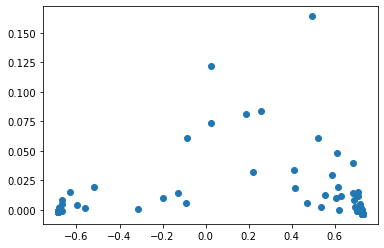

In [76]:
# M = np.array(preds)
preds = np.array(preds)
pca = PCA(n_components=2)
reduced = pca.fit_transform(preds)
t = reduced.transpose()
plt.scatter(t[0], t[1])
plt.show()

In [61]:
# a = 201
# b = 205
# plt.scatter(t[0][a:b], t[1][a:b])
# plt.show()

In [52]:
# test_images[a:b]

['./EyesDatasetTest/003897.jpg',
 './EyesDatasetTest/003898.jpg',
 './EyesDatasetTest/003899.jpg']

In [133]:
# kmeans = KMeans(n_clusters=2, random_state=0).fit(preds)
# labels = kmeans.labels_

In [79]:
kmeans = MiniBatchKMeans(n_clusters=2,
                         random_state=1,
                         batch_size=33,
                         max_iter=5000).fit(preds)
labels = kmeans.predict(preds)

In [80]:
for img_name, label in zip(test_images, labels):
    label_path = os.path.join(str(label))
    if not os.path.exists(label_path):
        os.makedirs(label_path)
    save_path = os.path.join(label_path, img_name[-10:])
    img = Image.open(img_name)
    if False:
        img = img.resize((48, 48), Image.ANTIALIAS)
    with open(save_path, 'w') as f:            
        img.save(f)

In [81]:
test_images_ones = get_image_names_from_dir("./1/", full=True)
test_images_zeros = get_image_names_from_dir("./0/", full=True)

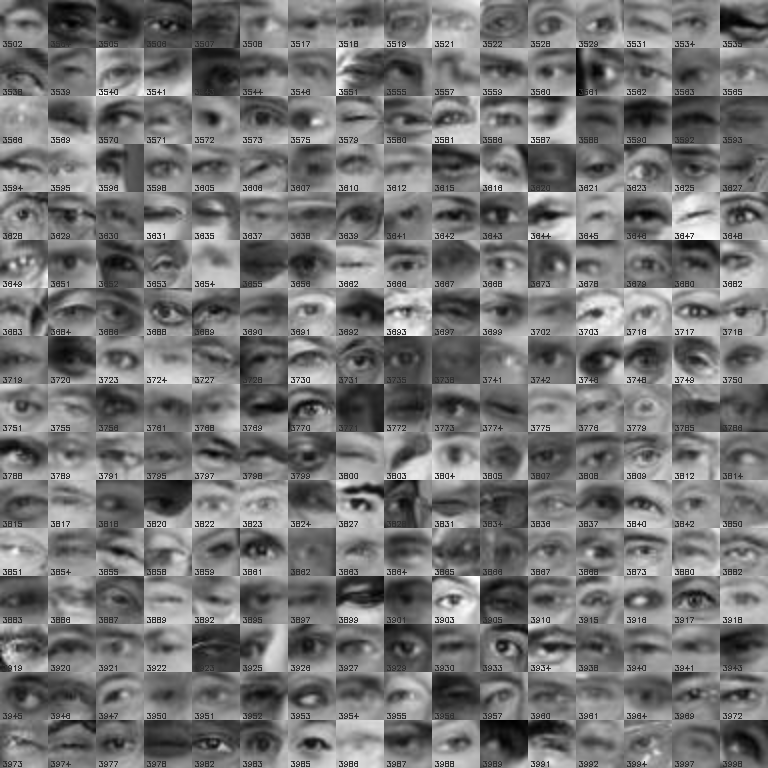

In [82]:
show_images(test_images_ones, randomize=False, mark=True)

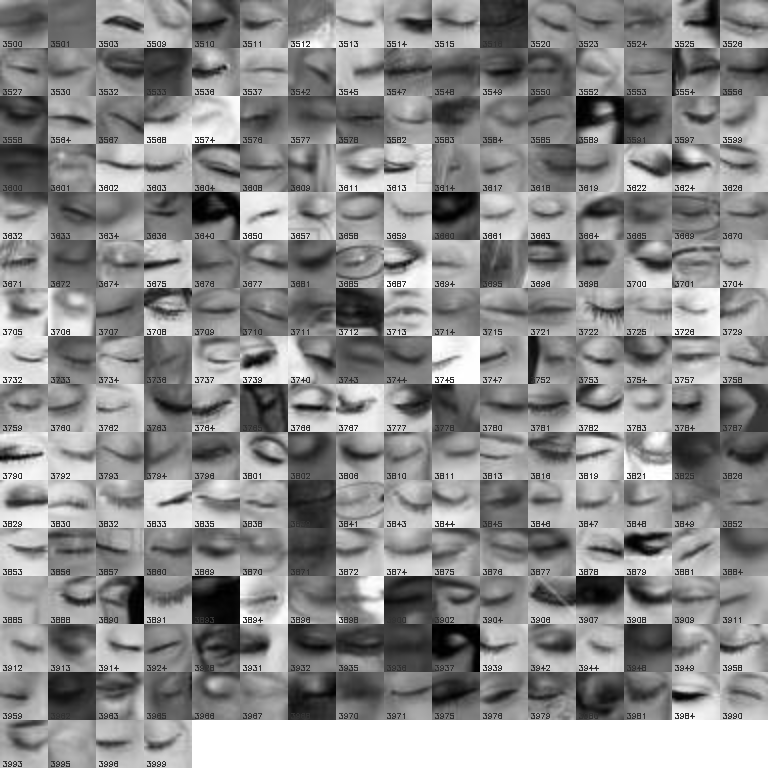

In [83]:
show_images(test_images_zeros, randomize=False, mark=True)